Importing the libraries

In [797]:
import pandas as pd

# Algoritms
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

# data visualization
import seaborn as sns
sns.set(style="white")
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

Getting the data

In [798]:
train_df = pd.read_csv("dataset/train.csv")
test_df = pd.read_csv("dataset/test.csv")

Looking at the data

In [799]:
train_df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [800]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Pandas_profiling provides a detailed report of the data but it is heavy

In [801]:
#import pandas_profiling
#train_df.profile_report()

Interpreting the data

survival: Yes=1, No=0
PassengerId: Unique Id of a passenger
pclass: Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
sex: male or female    
Age: age in years     
sibsp: number of siblings / spouses aboard the Titanic     
parch: number of parents / children aboard the Titanic     
ticket: Ticket number     
fare: Passenger fare     
cabin: Cabin number     
embarked: Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

In [802]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


See correlations

In [803]:
pd.DataFrame(abs(train_df.corr()['Survived']).sort_values(ascending = False))

,Survived
Survived,1.000000
Pclass,0.338481
Fare,0.257307
Parch,0.081629
Age,0.077221
SibSp,0.035322
PassengerId,0.005007


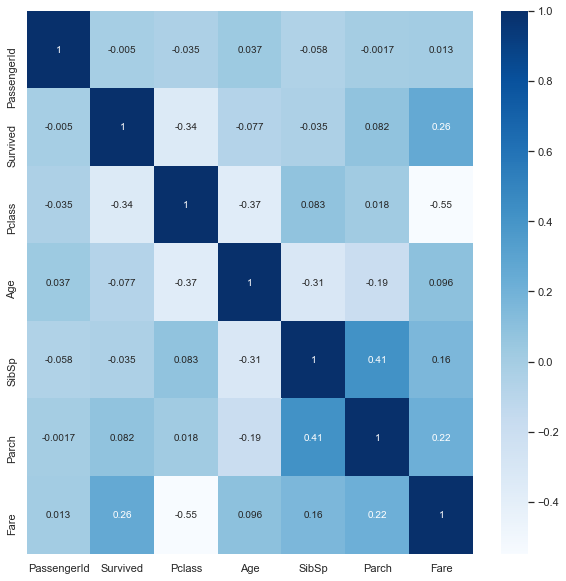

In [804]:
plt.figure(figsize=(10,10))
sns.heatmap(train_df.corr(), annot=True, cmap="Blues")

38% of Passengers survived

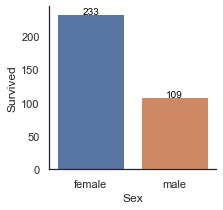

In [805]:
#plt.figure(figsize=(2,2))
#sns.barplot(x='Sex',y='Survived',data=train_df,ci=None)

groupedvalues = train_df.groupby('Sex').sum().reset_index()

plt.figure(figsize=(3,3))
g=sns.barplot(x='Sex',y='Survived',data=groupedvalues,ci=None)

for index, row in groupedvalues.iterrows():
    g.text(row.name,row.Survived,s=round(row.Survived,2), color='black', ha="center")

sns.despine()

70% of women survived compared to 20% of men

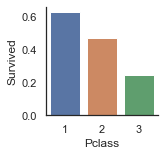

In [806]:
plt.figure(figsize=(2,2))
sns.barplot(x='Pclass', y='Survived', data=train_df,ci=None)
sns.despine()

60% in the first Class survived, compared to 20% in third Class

Missing values

In [807]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head()

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Fare,0,0.0
Ticket,0,0.0


I will drop Name and Ticket because they are irrelevant and Cabin because 77,1% is missing

In [808]:
ids=test_df['PassengerId']

train_df.drop(['Name','PassengerId', 'Ticket', 'Cabin'], axis=1, inplace=True)
test_df.drop(['Name','PassengerId', 'Ticket', 'Cabin'], axis=1, inplace=True)

I will substitute the missing values with the median

In [809]:
from sklearn.impute import SimpleImputer as Imputer
imputer = Imputer(strategy="median")

train_numerico = train_df.drop(['Sex','Embarked'], axis=1)
test_numerico = test_df.drop(['Sex','Embarked'], axis=1)

imputer.fit(train_numerico)
train_no_null = imputer.transform(train_numerico)

imputer.fit(test_numerico)
test_no_null = imputer.transform(test_numerico)

train_tr = pd.DataFrame(train_no_null, columns=train_numerico.columns)
test_tr = pd.DataFrame(test_no_null, columns=test_numerico.columns)

In [810]:
total = train_tr.isnull().sum().sort_values(ascending=False)
percent_1 = train_tr.isnull().sum()/train_tr.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head()

,Total,%
Fare,0,0.0
Parch,0,0.0
SibSp,0,0.0
Age,0,0.0
Pclass,0,0.0


One Hot Encoding - transforming strings into numerical categories

In [811]:
train_cat = train_df[['Sex', 'Embarked']]
test_cat = test_df[['Sex', 'Embarked']]
train_cat_encoded = pd.get_dummies(train_cat)
test_cat_encoded = pd.get_dummies(test_cat)

In [812]:
train_cat_encoded.head()

,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,1,0,0,1
1,1,0,1,0,0
2,1,0,0,0,1
3,1,0,0,0,1
4,0,1,0,0,1


In [813]:
new_train = train_tr.join(train_cat_encoded)
new_test = test_tr.join(test_cat_encoded)

In [814]:
new_train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.0,3.0,22.0,1.0,0.0,7.2500,0,1,0,0,1
1,1.0,1.0,38.0,1.0,0.0,71.2833,1,0,1,0,0
2,1.0,3.0,26.0,0.0,0.0,7.9250,1,0,0,0,1
3,1.0,1.0,35.0,1.0,0.0,53.1000,1,0,0,0,1
4,0.0,3.0,35.0,0.0,0.0,8.0500,0,1,0,0,1


Data is ready for Machine Learing

In [815]:
from sklearn.model_selection import train_test_split

predictors = new_train.drop(['Survived'], axis=1)
target = train_df["Survived"]
x_train, x_val, y_train, y_val = train_test_split(predictors, target, test_size = 0.2, random_state = 0)

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

decisiontree = DecisionTreeClassifier()
decisiontree.fit(x_train, y_train)
y_pred = decisiontree.predict(x_val)
acc_decisiontree = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_decisiontree)

78.21


In [816]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(x_train, y_train)

y_prediction = random_forest.predict(x_val)

random_forest.score(x_train, y_train)
acc_random_forest = round(random_forest.score(x_train, y_train) * 100, 2)

print(acc_random_forest)

98.03


Time to predict

In [817]:
predictions = random_forest.predict(new_test)

Creating the submission

In [818]:
submission = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions.astype('int64') })
submission.to_csv('submission.csv', index=False)